In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import pickle 
import os
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable 
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image
from data_loader import get_loader 
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
vocabulary_path='./data/vocab.pkl'
with open(vocabulary_path, 'rb') as f:
    vocab = pickle.load(f)

In [4]:
image_path='./data/resized2014'
caption_img_path='./data/annotations/captions_train2014.json'
embed_size=256
hidden_size=512
num_layers=1
batch_size=128
crop_size=224
transform = transforms.Compose([ 
        transforms.RandomCrop(crop_size),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_loader = get_loader(image_path, caption_img_path, vocab,
                         transform, batch_size,
                         shuffle=True, num_workers=2)

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


In [5]:
for i in range(15):
    encoder_path='./models/encoder-%d-%d.pkl' % (i/3+1, 1000*(i%3+1))
    print(encoder_path)

./models/encoder-1-1000.pkl
./models/encoder-1-2000.pkl
./models/encoder-1-3000.pkl
./models/encoder-2-1000.pkl
./models/encoder-2-2000.pkl
./models/encoder-2-3000.pkl
./models/encoder-3-1000.pkl
./models/encoder-3-2000.pkl
./models/encoder-3-3000.pkl
./models/encoder-4-1000.pkl
./models/encoder-4-2000.pkl
./models/encoder-4-3000.pkl
./models/encoder-5-1000.pkl
./models/encoder-5-2000.pkl
./models/encoder-5-3000.pkl


In [6]:
def word_list(word_idx_list, vocab):
    """Take a list of word ids and a vocabulary from a dataset as inputs
    and return the corresponding words as a list.
    """
    word_list = []
    for i in range(len(word_idx_list)):
        vocab_id = word_idx_list[i]
        word = vocab.idx2word[vocab_id]
#         if word == vocab.end:
#             break
#         if word != vocab.start:
#             word_list.append(word)
        word_list.append(word)
    return word_list

In [7]:
print(type(data_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [8]:
loss_data=[]
perp_data=[]
bleu4_data = []

# Initialize smoothing function
smoothing = SmoothingFunction()

start_bleu = 0.0
total_bleu_4 = start_bleu

with torch.no_grad():
    for i, (images, captions, lengths) in enumerate(data_loader):
        if i>=15:
            break
        encoder = EncoderCNN(embed_size)
        encoder.eval()  # encoder evaluation mode
        decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
        decoder.eval()  # decoder evaluation mode
        encoder_path='./models/encoder-%d-%d.pkl' % (i/3+1, 1000*(i%3+1))
        decoder_path='./models/decoder-%d-%d.pkl' % (i/3+1, 1000*(i%3+1))
        encoder.load_state_dict(torch.load(encoder_path))
        decoder.load_state_dict(torch.load(decoder_path))
        criterion = nn.CrossEntropyLoss()

        if torch.cuda.is_available():
            images = images.cuda()
            captions = captions.cuda()
            encoder.cuda()
            decoder.cuda()
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        loss_data.append(loss.data)
        perp_data.append(np.exp(loss.data.cpu()))

        # Calculate the total Bleu-4 score for the batch
        batch_bleu_4 = 0.0
        # Iterate over outputs. Note: outputs[i] is a caption in the batch
        # outputs[i, j, k] contains the model's predicted score i.e. how
        # likely the j-th token in the i-th caption in the batch is the
        # k-th token in the vocabulary.
    #     print(outputs)
    #     print(captions)
        for j in range(0,128):
            predicted_ids = []
            for scores in outputs[j]:
                # Find the index of the token that has the max score
                predicted_ids.append(scores.argmax().item())
            # Convert word ids to actual words
            predicted_word_list = word_list(predicted_ids, vocab)
    #         print(j)
            caption_word_list = word_list(captions[j].cpu().numpy(), vocab)
    #         print(predicted_word_list)
    #         print(caption_word_list)
            # Calculate Bleu-4 score and append it to the batch_bleu_4 list
            batch_bleu_4 += sentence_bleu([caption_word_list],
                                          predicted_word_list,
                                          smoothing_function=smoothing.method1)
        total_bleu_4 += batch_bleu_4 / 20
        bleu4_data.append(batch_bleu_4)
        print('Epoch %d, Loss: %.4f, Perplexity: %5.4f, Bleu-4: %.4f' %(i+1, loss.data, np.exp(loss.data.cpu())
                                                          , batch_bleu_4))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/xdg-cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:03<00:00, 60.7MB/s] 


Epoch 1, Loss: 2.6417, Perplexity: 14.0367, Bleu-4: 0.0837
Epoch 2, Loss: 2.4120, Perplexity: 11.1564, Bleu-4: 0.1532
Epoch 3, Loss: 2.2631, Perplexity: 9.6131, Bleu-4: 0.0788
Epoch 4, Loss: 2.0976, Perplexity: 8.1468, Bleu-4: 0.1179
Epoch 5, Loss: 2.0762, Perplexity: 7.9744, Bleu-4: 0.1340
Epoch 6, Loss: 1.9839, Perplexity: 7.2708, Bleu-4: 0.1330
Epoch 7, Loss: 2.0264, Perplexity: 7.5870, Bleu-4: 0.1167
Epoch 8, Loss: 2.0963, Perplexity: 8.1358, Bleu-4: 0.0860
Epoch 9, Loss: 1.7927, Perplexity: 6.0057, Bleu-4: 0.1826
Epoch 10, Loss: 1.8114, Perplexity: 6.1192, Bleu-4: 0.1003
Epoch 11, Loss: 1.8498, Perplexity: 6.3587, Bleu-4: 0.1644
Epoch 12, Loss: 1.8580, Perplexity: 6.4112, Bleu-4: 0.0933
Epoch 13, Loss: 1.8508, Perplexity: 6.3646, Bleu-4: 0.1212
Epoch 14, Loss: 1.7737, Perplexity: 5.8925, Bleu-4: 0.1041
Epoch 15, Loss: 1.8782, Perplexity: 6.5415, Bleu-4: 0.1286


In [13]:
import matplotlib.pyplot as plt

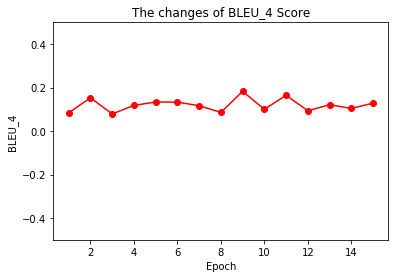

In [19]:
epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.ylabel('BLEU_4')
plt.xlabel("Epoch")
plt.ylim(-0.5, 0.5)
plt.plot(epoch, bleu4_data, color='red', marker='o', linestyle='solid')
plt.title('The changes of BLEU_4 Score')
plt.show()

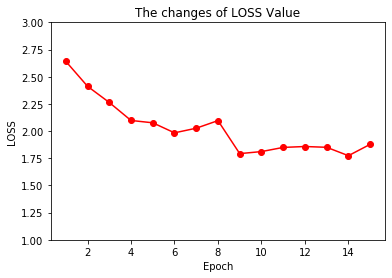

In [20]:
plt.ylabel('LOSS')
plt.xlabel("Epoch")
plt.ylim(1, 3)
plt.plot(epoch, loss_data, color='red', marker='o', linestyle='solid')
plt.title('The changes of LOSS Value')
plt.show()

## Reference
[TensorFlow Implementation of show and tell] (https://github.com/nikhilmaram/Show_and_Tell)
[Show and Tell: A Neural Image Caption Generator] (https://arxiv.org/pdf/1411.4555.pdf)
[PyTorch Implementation of show and tell] (https://github.com/ntrang086/image_captioning)